<a href="https://colab.research.google.com/github/Ulises-Zamarripa/plant-disease-detection/blob/main/Potato_%26_Tomato_Disease_Identification_Ulises_Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install torch --upgrade
#!pip install torchvision --upgrade

In [5]:
# @title
import kagglehub

# Correct dataset handle
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

print("Downloaded to:", path)

import os, sys
from contextlib import redirect_stderr
import io

100%|██████████| 329M/329M [00:09<00:00, 37.1MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1


In [6]:
import os
os.environ["OPENBLAS_VERBOSE"] = "0"
# to supress openblas warnings


import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# The base directory that contains the folders you listed
BASE_DIR = path + "/PlantVillage"
IMG_SIZE = 64

selected_classes = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato__Tomato_mosaic_virus",
    "Tomato__Tomato_YellowLeaf__Curl_Virus",
    "Tomato_healthy"
]

images = []
labels = []

class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}

for cls in selected_classes:
    folder = os.path.join(BASE_DIR, cls)
    print("Loading:", folder)

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(class_to_idx[cls])

images = np.array(images)
labels = np.array(labels)

print("Loaded images:", images.shape)
print("Loaded labels:", labels.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Loading: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage/Potato___Early_blight
Loading: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage/Potato___Late_blight
Loading: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage/Potato___healthy
Loading: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage/Tomato__Tomato_mosaic_virus
Loading: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
Loading: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage/Tomato_healthy
Loaded images: (7324, 64, 64, 3)
Loaded labels: (7324,)
Train: (5859, 64, 64, 3)
Test: (1465, 64, 64, 3)


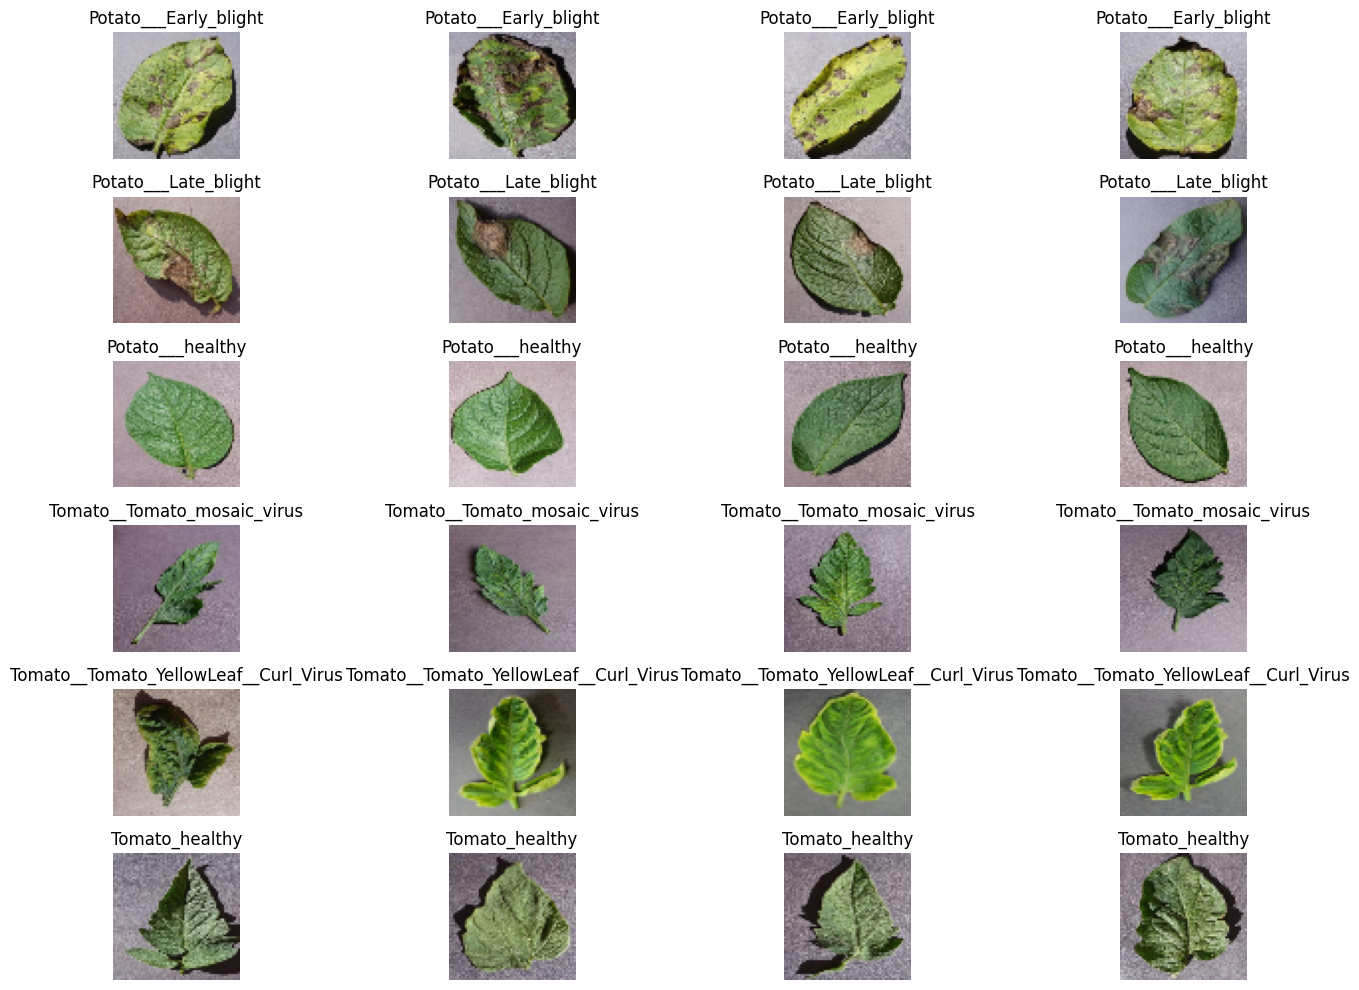

In [7]:
import matplotlib.pyplot as plt

def show_samples_per_class(X, y, class_names, samples=4):
    plt.figure(figsize=(15, 10))

    for idx, cls in enumerate(class_names):
        cls_idx = class_to_idx[cls]
        cls_images = X[y == cls_idx]

        for i in range(samples):
            plt.subplot(len(class_names), samples, idx * samples + i + 1)
            plt.imshow(cv2.cvtColor(cls_images[i], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(cls)

    plt.tight_layout()
    plt.show()

show_samples_per_class(images, labels, selected_classes, samples=4)

In [8]:
# Flatten images for KNN
X_train_knn = X_train.reshape(len(X_train), -1) / 255.0
X_test_knn  = X_test.reshape(len(X_test), -1) / 255.0

print("KNN train shape:", X_train_knn.shape)
print("KNN test shape:", X_test_knn.shape)


KNN train shape: (5859, 12288)
KNN test shape: (1465, 12288)


In [9]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=3, algorithm="kd_tree")
knn.fit(X_train_knn, y_train)

y_pred_knn = knn.predict(X_test_knn)

acc_knn = accuracy_score(y_test, y_pred_knn)
print("🔵 KNN Accuracy:", acc_knn)

🔵 KNN Accuracy: 0.783617747440273


In [10]:
print("\nClassification Report (KNN):\n")
print(classification_report(y_test, y_pred_knn, target_names=selected_classes))


Classification Report (KNN):

                                       precision    recall  f1-score   support

                Potato___Early_blight       0.96      0.43      0.60       200
                 Potato___Late_blight       0.51      0.81      0.63       200
                     Potato___healthy       0.80      0.27      0.40        30
          Tomato__Tomato_mosaic_virus       0.94      0.40      0.56        75
Tomato__Tomato_YellowLeaf__Curl_Virus       0.89      0.96      0.92       642
                       Tomato_healthy       0.76      0.78      0.77       318

                             accuracy                           0.78      1465
                            macro avg       0.81      0.61      0.65      1465
                         weighted avg       0.82      0.78      0.77      1465



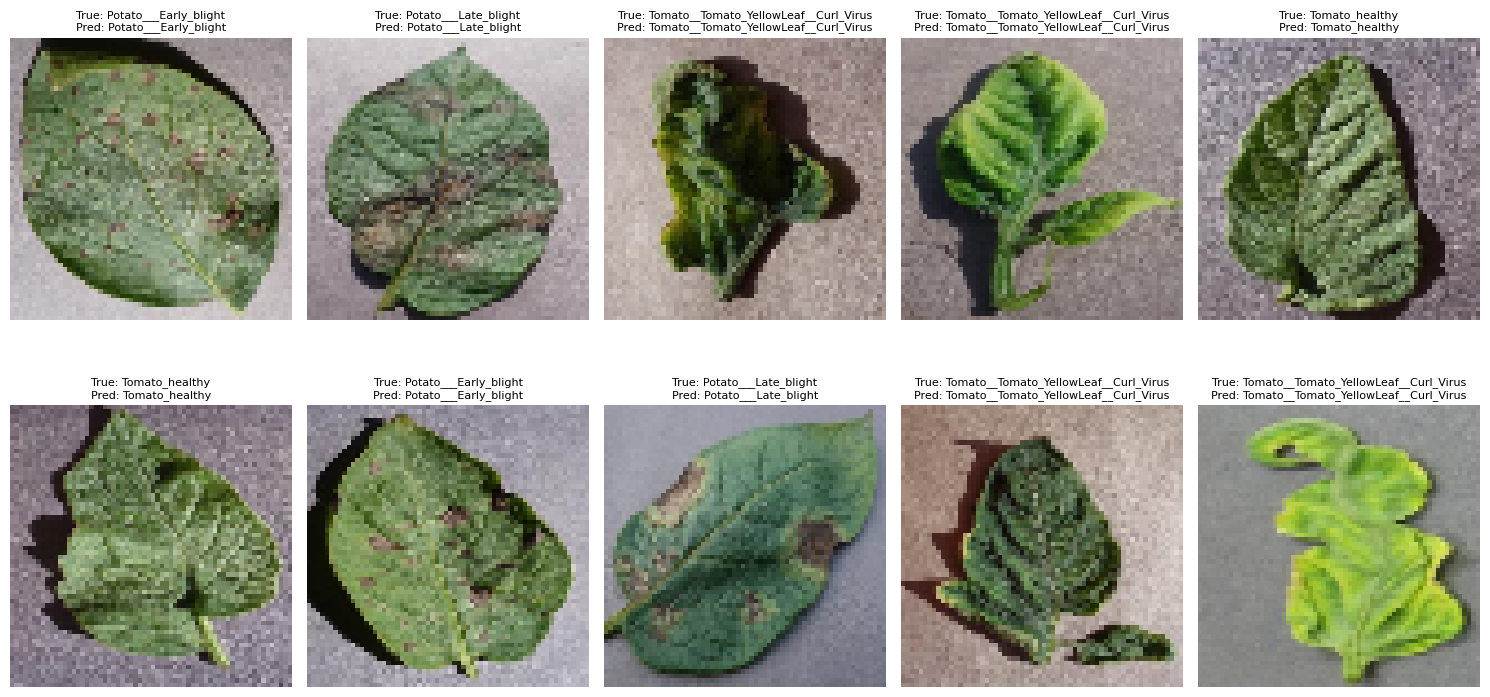

In [11]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

for i in range(10):
    idx = random.randint(0, len(X_test)-1)

    img = X_test[idx]
    img_flat = img.reshape(1, -1) / 255.0

    pred = knn.predict(img_flat)[0]
    true = y_test[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"True: {selected_classes[true]}\nPred: {selected_classes[pred]}", fontsize=8)

plt.tight_layout()
plt.show()

In [12]:
# Normalize + Flatten for ANN
X_train_ann = X_train.reshape(len(X_train), -1) / 255.0
X_test_ann  = X_test.reshape(len(X_test), -1) / 255.0

num_classes = len(selected_classes)

print("ANN train shape:", X_train_ann.shape)
print("ANN test shape:", X_test_ann.shape)

ANN train shape: (5859, 12288)
ANN test shape: (1465, 12288)


In [13]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


import tensorflow as tf
from tensorflow.keras import layers, models

ann = models.Sequential([
    layers.Dense(512, activation="relu", input_shape=(IMG_SIZE*IMG_SIZE*3,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

ann.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ann.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,456,966 (24.63 MB)

 Trainable params: 6,456,966 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_ann = ann.fit(
    X_train_ann,
    y_train,
    epochs=6,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/6
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.8650 - loss: 0.3968 - val_accuracy: 0.8430 - val_loss: 0.3983
Epoch 2/6
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.8620 - loss: 0.3805 - val_accuracy: 0.8703 - val_loss: 0.3527
Epoch 3/6
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.8749 - loss: 0.3421 - val_accuracy: 0.8515 - val_loss: 0.4263
Epoch 4/6
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.8760 - loss: 0.3304 - val_accuracy: 0.8601 - val_loss: 0.3834
Epoch 5/6
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.8902 - loss: 0.3207 - val_accuracy: 0.8925 - val_loss: 0.3059
Epoch 6/6
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9104 - loss: 0.2503 - val_accuracy: 0.8524 - val_loss: 0.3750


In [16]:
loss_ann, acc_ann = ann.evaluate(X_test_ann, y_test)
print("\n🟠 ANN Test Accuracy:", acc_ann)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8532 - loss: 0.3998

🟠 ANN Test Accuracy: 0.849829375743866


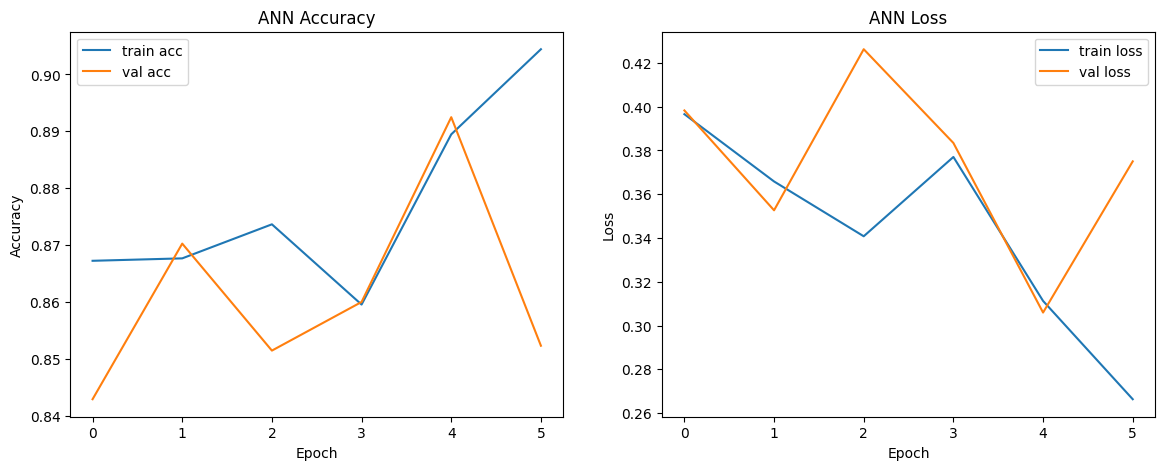

In [17]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_ann.history['accuracy'], label='train acc')
plt.plot(history_ann.history['val_accuracy'], label='val acc')
plt.title("ANN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_ann.history['loss'], label='train loss')
plt.plot(history_ann.history['val_loss'], label='val loss')
plt.title("ANN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

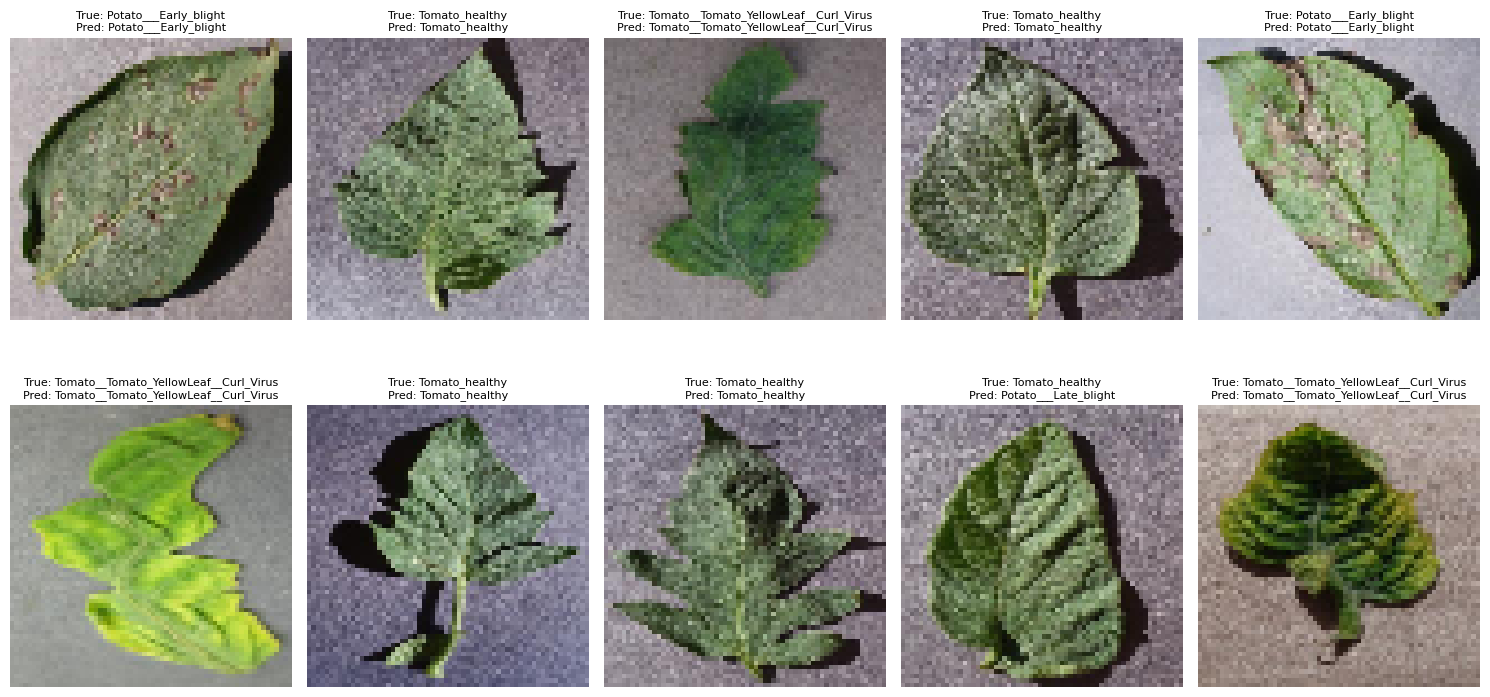

In [18]:
import random

plt.figure(figsize=(15,8))

for i in range(10):
    idx = random.randint(0, len(X_test)-1)

    img = X_test[idx]
    img_flat = X_test_ann[idx].reshape(1, -1)

    pred = ann.predict(img_flat, verbose=0)[0].argmax()
    true = y_test[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"True: {selected_classes[true]}\nPred: {selected_classes[pred]}", fontsize=8)

plt.tight_layout()
plt.show()

In [19]:
X_train_cnn = X_train / 255.0
X_test_cnn  = X_test / 255.0

print("CNN train shape:", X_train_cnn.shape)
print("CNN test shape:", X_test_cnn.shape)

CNN train shape: (5859, 64, 64, 3)
CNN test shape: (1465, 64, 64, 3)


In [20]:
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,726 (4.36 MB)

 Trainable params: 1,142,726 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history_cnn = cnn.fit(
    X_train_cnn, y_train,
    epochs=6,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 72s 459ms/step - accuracy: 0.6462 - loss: 0.9794 - val_accuracy: 0.8848 - val_loss: 0.3273
Epoch 2/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 353ms/step - accuracy: 0.9119 - loss: 0.2430 - val_accuracy: 0.9437 - val_loss: 0.1502
Epoch 3/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 368ms/step - accuracy: 0.9405 - loss: 0.1671 - val_accuracy: 0.9394 - val_loss: 0.1534
Epoch 4/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 350ms/step - accuracy: 0.9512 - loss: 0.1366 - val_accuracy: 0.9539 - val_loss: 0.1189
Epoch 5/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 373ms/step - accuracy: 0.9752 - loss: 0.0700 - val_accuracy: 0.9846 - val_loss: 0.0636
Epoch 6/6
147/147 ━━━━━━━━━━━━━━━━━━━━ 53s 360ms/step - accuracy: 0.9833 - loss: 0.0495 - val_accuracy: 0.9812 - val_loss: 0.0508


In [22]:
loss_cnn, acc_cnn = cnn.evaluate(X_test_cnn, y_test)
print("\n🔴 CNN Test Accuracy:", acc_cnn)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9741 - loss: 0.0780

🔴 CNN Test Accuracy: 0.9767917990684509


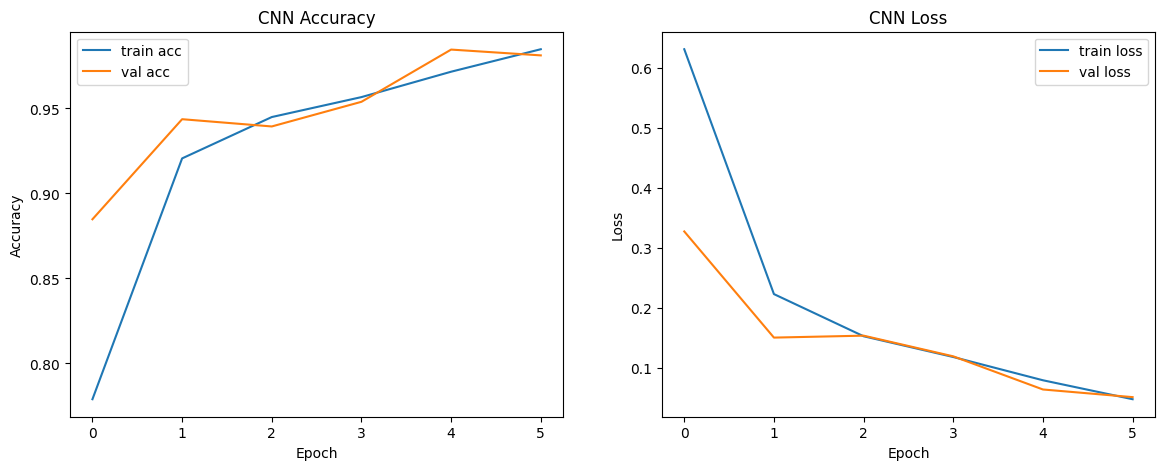

In [23]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='train acc')
plt.plot(history_cnn.history['val_accuracy'], label='val acc')
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='train loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

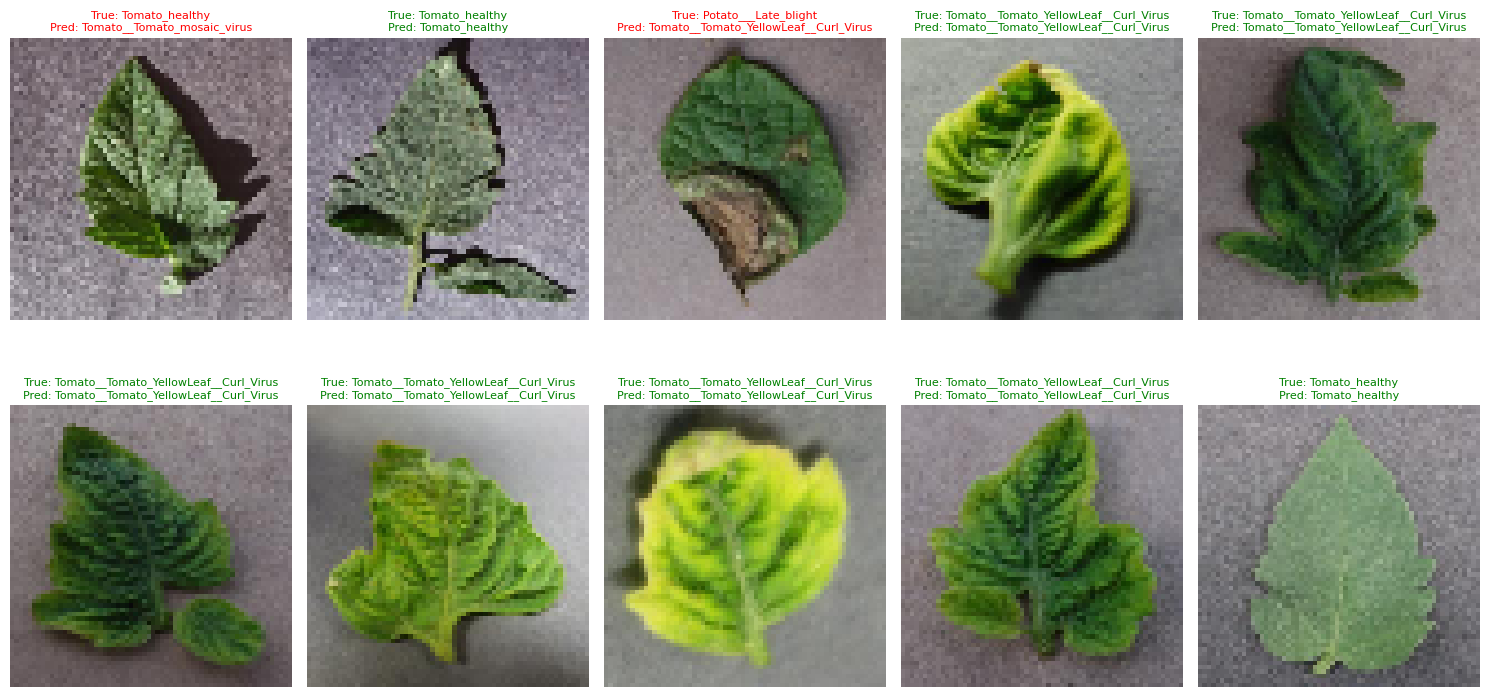

In [24]:
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

plt.figure(figsize=(15, 8))

for i in range(10):
    idx = random.randint(0, len(X_test) - 1)

    img = X_test[idx]
    img_norm = img.reshape(1, IMG_SIZE, IMG_SIZE, 3) / 255.0

    pred = cnn.predict(img_norm, verbose=0)[0].argmax()
    true = y_test[idx]

    color = "green" if pred == true else "red"

    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(
        f"True: {selected_classes[true]}\nPred: {selected_classes[pred]}",
        color=color,
        fontsize=8
    )

plt.tight_layout()
plt.show()